In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("../")

import gp
from banana_utils import banana_arff_to_tensor, choose_m_from_n

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.float64)

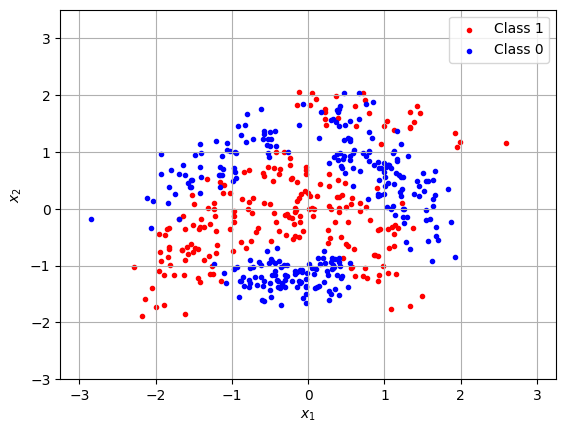

In [2]:
X, t = banana_arff_to_tensor('../data/banana-dataset.arff')

# use subset of data to begin with
inds, _ = choose_m_from_n(X.shape[0], 500)
X, t = X[inds], t[inds]

plt.scatter(X[:,0][t == 1], X[:,1][t == 1], color='red', marker='.', label='Class 1')
plt.scatter(X[:,0][t == 0], X[:,1][t == 0], color='blue', marker='.', label='Class 0')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim([-3.25, 3.25])
plt.ylim([-3.0, 3.5])
plt.legend()
plt.grid()
plt.show()

In [29]:
num_inducing = 50
num_orthog_inducing = 50

sovgpc = gp.models.SparseOrthogonalVariationalGaussianProcess(
    X.shape[1],
    num_inducing,
    num_orthog_inducing,
    likelihood='Bernoulli',
    covariance_function='exponential',
    mean_function='constant',
    train_mean_func=True,
    l=1.0,
    train_l=True,
    ard=True,
)

sovgpc.init_inducing_variables(X, t)

tracker = gp.training.train_variational_gp(
    sovgpc,
    X,
    t,
    epochs=1000,
    learning_rate=1e-2,
    final_learning_rate=5e-3,
    num_samples=5,
    batch_size=250,
    unfreeze_trainable_hypers_at_step=200,
)

accuracy = float(gp.utils.evaluate_gp_classifier(sovgpc, X, t))
print('Accuracy: ', accuracy)

100%|██████████| 2000/2000 [00:32<00:00, 61.97it/s, elbo=-167, Exp ll=-109, kl_u=23.3, kl_v=34.7, mean.c=-0.107, Epochs=1e+3]  


Accuracy:  0.924


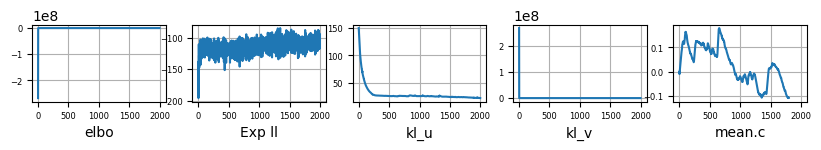

In [30]:
fig, ax = plt.subplots(1, len(tracker.items()), figsize=(2*len(tracker.items()), 1), sharex=True)

for j, (key, value) in enumerate(tracker.items()):
    ax[j].plot(value)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    ax[j].grid()
    ax[j].set_xlabel(key, fontsize=10)
 
plt.show()

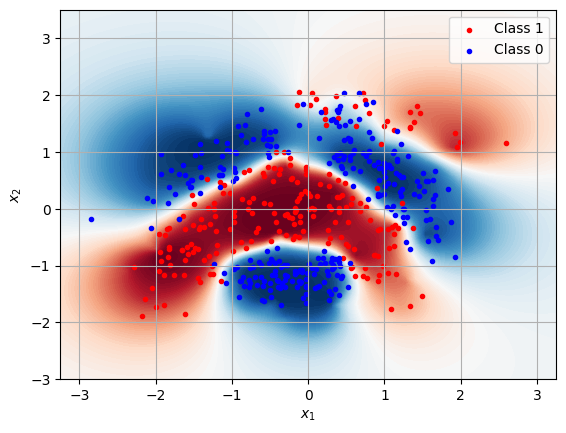

In [31]:
xx1, xx2, pred_probs = gp.utils.get_predictive_dist_grid(sovgpc, X, [-3.25, 3.25], [-3.0, 3.5])
plt.contourf(xx1, xx2, 1-pred_probs, torch.linspace(0.0, 1.0, 100), cmap='RdBu')
# plt.contour(xx1, xx2, 1-pred_probs, [0.5], colors=['black'])
plt.scatter(X[:,0][t == 1], X[:,1][t == 1], color='red', marker='.', label='Class 1')
plt.scatter(X[:,0][t == 0], X[:,1][t == 0], color='blue', marker='.', label='Class 0')
# plt.scatter(svgpc.Z[:,0].detach(), svgpc.Z[:,1].detach(), marker='x', label='Inducing input')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim([-3.25, 3.25])
plt.ylim([-3.0, 3.5])
plt.legend()
plt.grid()
plt.show()


In [11]:
sovgpc.prior.kernel.l.detach().data

tensor([0.8422, 0.6209])